In [ ]:
import os
import torch
import clip
import numpy as np
from PIL import Image
import umap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from pathlib import Path

import seaborn as sns

c:\Users\Friis\anaconda3\envs\ProjectWorkEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\Friis\anaconda3\envs\ProjectWorkEnv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Friis\anaconda3\envs\ProjectWorkEnv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


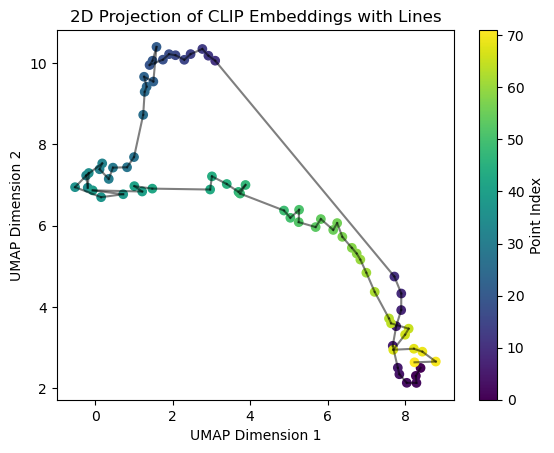

In [2]:
def load_and_embed_images(image_paths, device):
    # Load the CLIP model
    model, preprocess = clip.load("ViT-B/32", device)
    
    embeddings = []
    
    for image_path in image_paths:
        # Open and preprocess the image
        image = Image.open(image_path)
        image_input = preprocess(image).unsqueeze(0).to(device)
        
        # Get the image embeddings using CLIP
        with torch.no_grad():
            image_features = model.encode_image(image_input)
        
        # Normalize the features and append them to the embeddings list
        image_features /= image_features.norm(dim=-1, keepdim=True)
        embeddings.append(image_features.cpu().numpy())
    
    # Convert embeddings list to numpy array
    return np.vstack(embeddings)

# Function to perform UMAP projection on the embeddings
def project_embeddings_2d(embeddings, random_seed):
    reducer = umap.UMAP(random_state=random_seed)
    umap_embeddings = reducer.fit_transform(embeddings)
    
    return umap_embeddings  # Return the UMAP coordinates

# Function to visualize the 2D projection, draw lines between successive points, and add a colorbar
def visualize_2d_projection(umap_embeddings):
    # Generate a colormap based on the index of each point (0 to 71)
    cmap = plt.get_cmap("viridis")
    norm = Normalize(vmin=0, vmax=len(umap_embeddings)-1)
    
    # Plot points with color based on their index
    scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=np.arange(len(umap_embeddings)), cmap=cmap, norm=norm)
    
    # Draw lines between successive points
    for i in range(1, len(umap_embeddings)):
        plt.plot([umap_embeddings[i-1, 0], umap_embeddings[i, 0]], 
                 [umap_embeddings[i-1, 1], umap_embeddings[i, 1]], 'k-', alpha=0.5)
    
    plt.title("2D Projection of CLIP Embeddings with Lines")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    
    # Add colorbar to the plot
    cbar = plt.colorbar(scatter)
    cbar.set_label("Point Index")
    
    plt.show()

def main():
    object_number = 4
    image_folder = Path(f"../Data/coil-20/{object_number}/").resolve()
    image_paths = [os.path.join(image_folder, f"obj{object_number}__{i}.png") for i in range(0, 72)]
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load and embed images using CLIP
    embeddings = load_and_embed_images(image_paths, device)
    
    # Project embeddings to 2D using UMAP
    umap_embeddings = project_embeddings_2d(embeddings, random_seed = 42)
    
    # Visualize the 2D projection with colorbar and lines between points
    visualize_2d_projection(umap_embeddings)
    
    # Return the x and y coordinates for further use
    return umap_embeddings[:, 0], umap_embeddings[:, 1]  # x and y coordinates

# Run the script and get the x and y coordinates
if __name__ == "__main__":
    x_coords, y_coords = main()


In [3]:
def calculate_angles(x_coords, y_coords):

    points = np.column_stack((x_coords, y_coords))
    num_points = len(points)
    padded_points = np.vstack((points[-1], points, points[0]))
    angles = []
    lengths = []

    for i in range(1, num_points + 1):  # Loop over original points (ignoring padding)
        prev_point = padded_points[i - 1]
        curr_point = padded_points[i]
        next_point = padded_points[i + 1]

        # Vectors from current to prev/next
        vec_prev = prev_point - curr_point
        vec_next = next_point - curr_point

        # Compute norms (magnitudes)
        norm_prev = np.linalg.norm(vec_prev)
        norm_next = np.linalg.norm(vec_next)

        lengths.append(norm_prev)

        # Check for zero-length vectors (threshold for floating-point precision)
        if norm_prev < 1e-8 or norm_next < 1e-8:
            print(f"Warning: Zero-length vector at point {i-1} (coords: {curr_point})")
            angles.append(np.nan)
            continue

        # Compute cosine of the angle
        cos_theta = np.dot(vec_prev, vec_next) / (norm_prev * norm_next)
        cos_theta = np.clip(cos_theta, -1.0, 1.0)  # Ensure valid arccos input

        # Get angle in degrees
        angle_deg = np.degrees(np.arccos(cos_theta))

        # Smallest angle (0° to 180°)
        smallest_angle = min(angle_deg, 360 - angle_deg)
        angles.append(smallest_angle)

    return angles, lengths

angles, lengths = calculate_angles(x_coords, y_coords)

def CV(input):
    cvar = np.std(input) / np.mean(input)
    return cvar

print(CV(lengths))
print(CV(angles))

1.6547676
0.48441058


(73,)


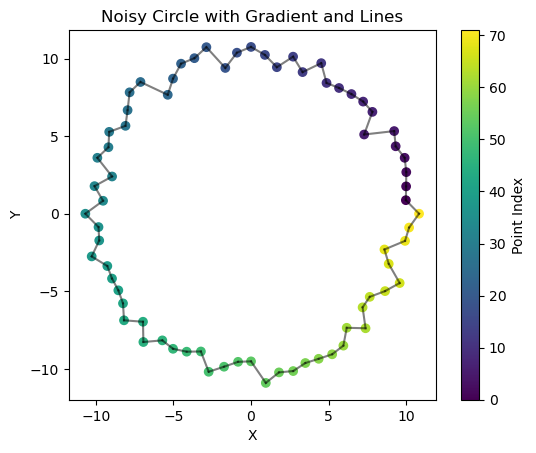

In [4]:
num_points = 73  # number of points on the circle
radius = 10 # radius of the circle
noise_level = 0.5

# Generate x and y coordinates using parametric equations for a circle
theta = np.linspace(0, 2 * np.pi, num_points)
noise = np.random.normal(0, noise_level, num_points)
print(noise.shape)
x_coords = (noise + radius) * np.cos(theta) 
y_coords = (noise + radius) * np.sin(theta) 
x_coords = x_coords[1:]
y_coords = y_coords[1:]


cmap = plt.get_cmap("viridis")
norm = Normalize(vmin=0, vmax=len(x_coords)-1)

# Plot points with color based on their index
scatter = plt.scatter(x_coords, y_coords, c=np.arange(len(x_coords)), cmap=cmap, norm=norm)

# Draw lines between successive points
for i in range(1, len(x_coords)):
    plt.plot([x_coords[i-1], x_coords[i]], [y_coords[i-1], y_coords[i]], 'k-', alpha=0.5)

# To close the circle, draw a line from the last point to the first
plt.plot([x_coords[-1], x_coords[0]], [y_coords[-1], y_coords[0]], 'k-', alpha=0.5)

# Add a colorbar to the plot
cbar = plt.colorbar(scatter)
cbar.set_label("Point Index")

plt.title("Noisy Circle with Gradient and Lines")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal', adjustable='box')  # Ensure equal scaling of axes
plt.show()

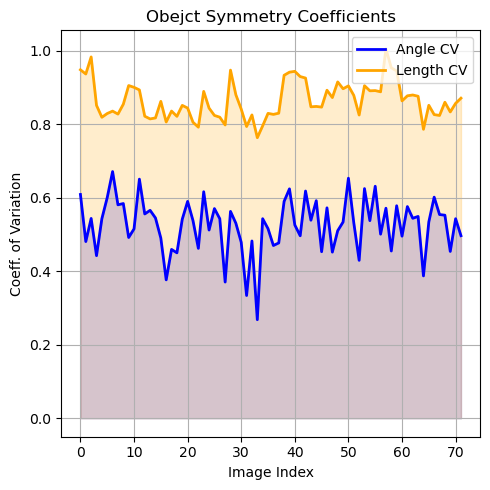

In [5]:
def sliding_window(lst, window):
    n = len(lst)
    bins = []
    angleCVs = []
    lengthCVs = []

    for i in range(n):
        bin_indices = [(i + j) % n for j in range(-window, window + 1)]
        bin_values = [lst[j] for j in bin_indices]
        bins.append(bin_values)
    
    for bin in bins:
        x_coords = [pt[0] for pt in bin]
        y_coords = [pt[1] for pt in bin]
        
        angles, lengths = calculate_angles(x_coords, y_coords)
        angleCVs.append(CV(angles))
        lengthCVs.append(CV(lengths))
    
    return angleCVs, lengthCVs

def plot_coefficients(angleCVs, lengthCVs):
    x = np.arange(len(angleCVs))

    plt.figure(figsize=(5, 5))
    plt.plot(x, angleCVs, label='Angle CV', color='blue', linewidth=2)
    plt.plot(x, lengthCVs, label='Length CV', color='orange', linewidth=2)

    plt.fill_between(x, angleCVs, alpha=0.2, color='blue')
    plt.fill_between(x, lengthCVs, alpha=0.2, color='orange')

    plt.title("Obejct Symmetry Coefficients")
    plt.xlabel("Image Index")
    plt.ylabel("Coeff. of Variation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

points = np.column_stack((x_coords, y_coords))
angles, lengths = sliding_window(points, 3)

plot_coefficients(angles, lengths)


0.07465170474574184 72
0.008797787775475005
0.05066991779158137 72
0.005971507078765348


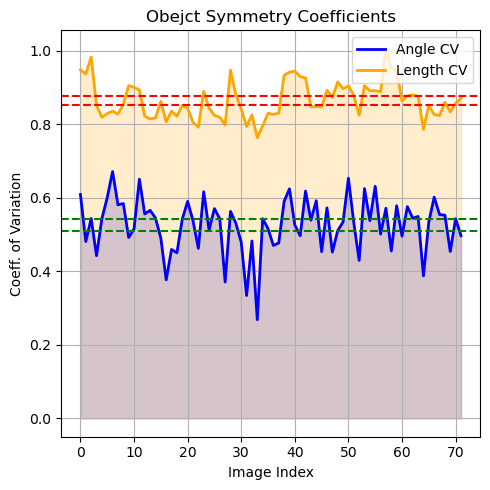

In [6]:
def CI95(x):
    n = len(x)

    x_mean = np.mean(x)
    sample_std = np.std(x, ddof=1)
    print(sample_std, n)
    ste = sample_std / np.sqrt(n)
    print(ste)
    z = 1.96

    lower_bound = x_mean - z * ste
    upper_bound = x_mean + z * ste

    return lower_bound, upper_bound

def plot_coefficients_confidence(angleCVs, lengthCVs, angleInterval, lengthInterval):
    x = np.arange(len(angleCVs))

    plt.figure(figsize=(5, 5))
    plt.plot(x, angleCVs, label='Angle CV', color='blue', linewidth=2)
    plt.axhline(angleInterval[0], color='green', linestyle='--')
    plt.axhline(angleInterval[1], color='green', linestyle='--')

    plt.plot(x, lengthCVs, label='Length CV', color='orange', linewidth=2)
    plt.axhline(lengthInterval[0], color='red', linestyle='--')
    plt.axhline(lengthInterval[1], color='red', linestyle='--')

    plt.fill_between(x, angleCVs, alpha=0.2, color='blue')
    plt.fill_between(x, lengthCVs, alpha=0.2, color='orange')

    plt.title("Obejct Symmetry Coefficients")
    plt.xlabel("Image Index")
    plt.ylabel("Coeff. of Variation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

conf_interval_angle = CI95(angles)
conf_interval_length = CI95(lengths)
plot_coefficients_confidence(angles, lengths, conf_interval_angle, conf_interval_length)

In [ ]:
def plot_similarity_heatmap(sim_matrix):
    plt.figure(figsize=(8, 7))
    ax = sns.heatmap(sim_matrix, cmap="viridis", square=True, cbar=True, xticklabels=3, yticklabels=3)

  
    step = 3
    tick_positions = np.arange(0, sim_matrix.shape[0], step)
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(tick_positions, rotation=90, fontsize=8)
    ax.set_yticklabels(tick_positions, rotation=0, fontsize=8)

    

    plt.title("Cos-Sim Matrix Heatmap")
    plt.xlabel("Image Index")
    plt.ylabel("Image Index")
    plt.tight_layout()
    plt.show()

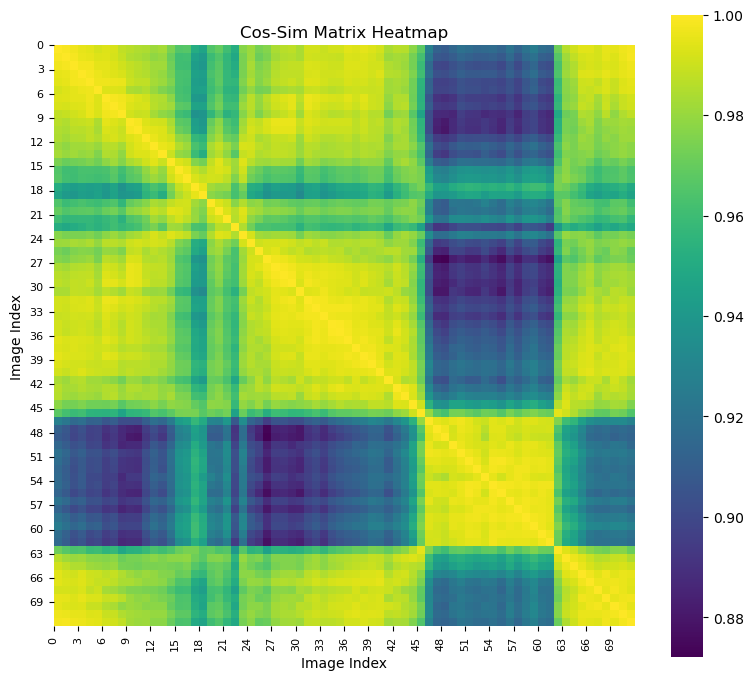

In [ ]:
#Makeshift codeblock for experimentation
from sklearn.decomposition import PCA

object_number = 18
image_folder = Path(f"../Data/coil-20/{object_number}/").resolve()
image_paths = [os.path.join(image_folder, f"obj{object_number}__{i}.png") for i in range(0, 72)]

device = "cuda" if torch.cuda.is_available() else "cpu"

embeddings = load_and_embed_images(image_paths, device)
pca = PCA()
pca.fit(embeddings)
#uncomment to visualize PCA, bit scuffed
#visualize_2d_projection((pca.components_[:2]  @ embeddings.T).T)#not UMAP here...

#to visualize different raw embeddings
cosine_sim_matrix = compute_cosine_similarity_matrix(embeddings)
plot_similarity_heatmap(cosine_sim_matrix)

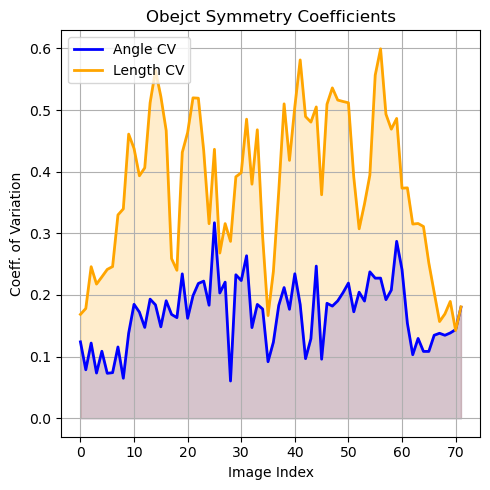

In [8]:
#Works for any dimensionality:::
def calculate_angles_nd(points):
    num_points = len(points)
    padded_points = np.vstack((points[-1], points, points[0]))
    angles = []
    lengths = []

    for i in range(1, num_points + 1):
        prev = padded_points[i - 1]
        curr = padded_points[i]
        next_ = padded_points[i + 1]

        vec_prev = prev - curr
        vec_next = next_ - curr

        norm_prev = np.linalg.norm(vec_prev)
        norm_next = np.linalg.norm(vec_next)

        lengths.append(norm_prev)

        if norm_prev < 1e-8 or norm_next < 1e-8:
            angles.append(np.nan)
            continue

        cos_theta = np.dot(vec_prev, vec_next) / (norm_prev * norm_next)
        cos_theta = np.clip(cos_theta, -1.0, 1.0)
        angle_deg = np.degrees(np.arccos(cos_theta))
        smallest_angle = min(angle_deg, 360 - angle_deg)
        angles.append(smallest_angle)

    return angles, lengths

def sliding_window_nd(points, window):
    n = len(points)
    angleCVs = []
    lengthCVs = []

    for i in range(n):
        indices = [(i + j) % n for j in range(-window, window + 1)]
        bin_points = np.array([points[j] for j in indices])
        angles, lengths = calculate_angles_nd(bin_points)
        angleCVs.append(CV(angles))
        lengthCVs.append(CV(lengths))

    return angleCVs, lengthCVs

points = embeddings  # shape (72, 512) for example
angle_CVs, length_CVs = sliding_window_nd(points, window=3)
plot_coefficients(angle_CVs, length_CVs)

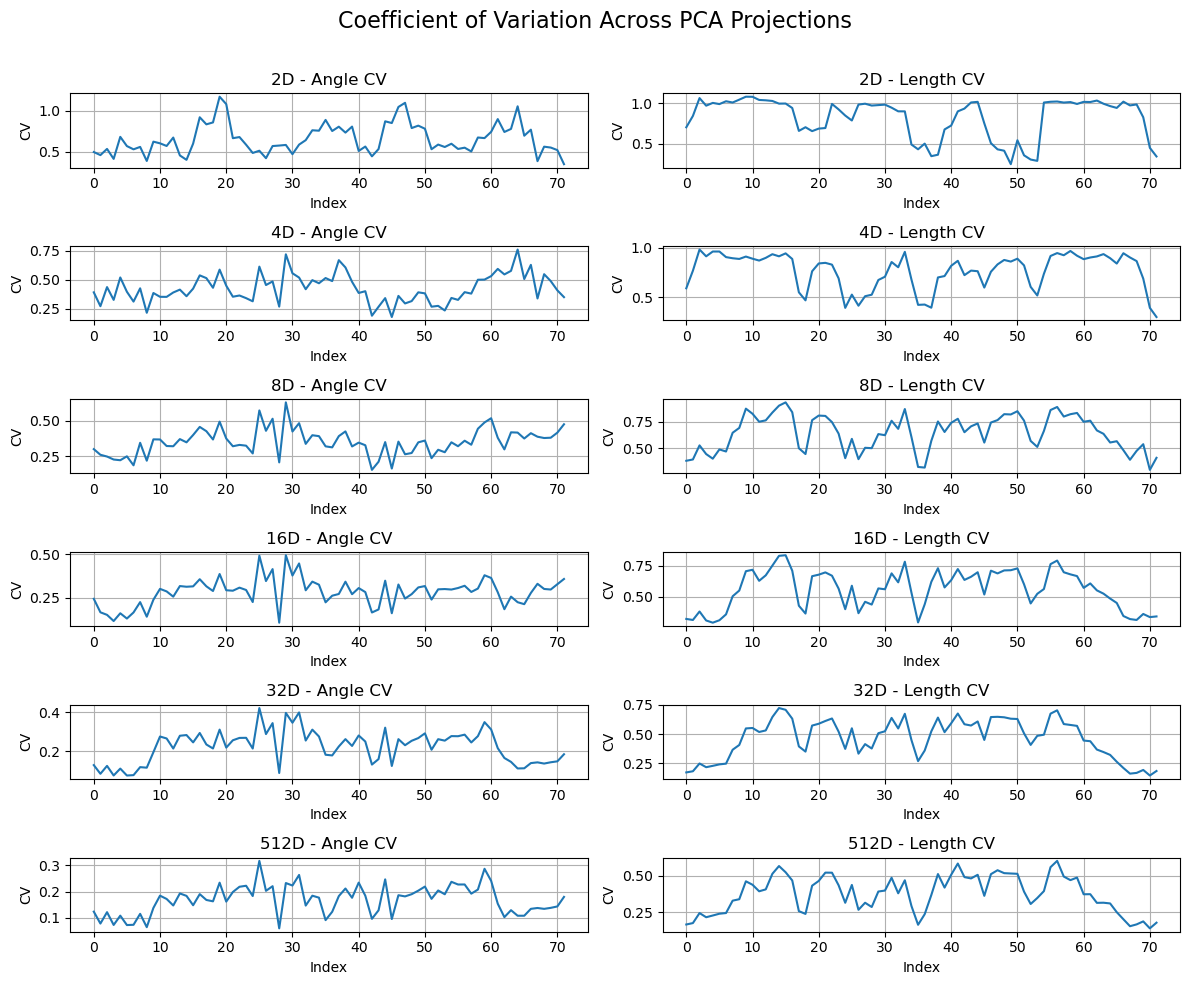

In [ ]:
projections = {
    "2D":   pca.components_[:2]   @ embeddings.T,
    "4D":   pca.components_[:4]   @ embeddings.T,
    "8D":   pca.components_[:8]   @ embeddings.T,
    "16D":  pca.components_[:16]  @ embeddings.T,
    "32D":  pca.components_[:32]  @ embeddings.T,
    "512D":  pca.components_  @ embeddings.T
}

fig, axs = plt.subplots(6, 2, figsize=(12, 10))
fig.suptitle("Coefficient of Variation Across PCA Projections", fontsize=16)

for idx, (label, proj) in enumerate(projections.items()):
    angle_CVs, length_CVs = sliding_window_nd(proj.T, window=3)  # transpose back

    axs[idx, 0].plot(angle_CVs)
    axs[idx, 0].set_title(f"{label} - Angle CV")

    axs[idx, 1].plot(length_CVs)
    axs[idx, 1].set_title(f"{label} - Length CV")

for ax in axs.flat:
    ax.set_xlabel("Index")
    ax.set_ylabel("CV")
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()